# 0. DATA620: Final Project Proposal - Federal Reserve Sentiment

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

# Setup

## Import Modules

In [15]:
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from textblob import Word

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

import spacy
import spacy.cli
from spacy.lang.en import English

from textatistic import Textatistic
#from wordcloud import WordCloud
import statsmodels.api as sm

import networkx as nx
import warnings
from scipy.stats import ttest_ind
plt.rcParams.update({'axes.facecolor':'orange'})

## Global Settings

In [16]:
random.seed(123)

## Global Functions

In [17]:
# Function that returns average word length
def avg_word_length(x):
    # Split the string into words
    words = x.split()
    # Compute length of each word and store in a separate list
    word_lengths = [len(word) for word in words]
    # Compute average word length
    avg_word_length = sum(word_lengths)/len(words)
    # Return average word length
    return(avg_word_length)


def filter_propn(s):
    
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    
    
    # Load model and create Doc object
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(s)

    # Generate lemmatized tokens
    lemmas = [token.lemma_ for token in doc]

    # Remove stopwords and non-alphabetic tokens
    a_lemmas = [lemma for lemma in lemmas 
                if lemma.isalpha() and lemma not in stopwords]

    a_lemmas = ' '.join(a_lemmas)
    doc_lemmas = nlp(a_lemmas)

    # Generate list of tokens and pos tags
    pos = [(token.text, token.pos_) for token in doc_lemmas]
    
    l = list(zip(*pos))[0]
    l = sorted(set(l))
    
    return ' '.join(l)


def get_city_name(n):
    nlp = spacy.load('en_core_web_sm')

    doc = nlp(n)
    places = [str(ent) for ent in doc.ents if ent.label_ in ['GPE', 'LOC']]

    return ' '.join(places)
   

<br>

# 1. Introduction

<br><br>

## Hypothesis

In the time leading up FOMC Meeting the Fed Chair and the Governors of the 12 Federal Reserve Banks will develop an economic outlook that will inform their vote at the FOMC Meeting. One way to measure transparency is to evaluate how well this economic outlook is communicated to the general public through speeches. Fortunately for this analysis the Fed tracks all speeches by it board of governors and posts them to www.federalreserve.gov with transcripts.

For this analysis we can categorize the periods between FOMC meeting by their outcome. In each meeting the interest rate target will either be increased, decreased or remain the same. For each type of FOMC meeting outcome we would like to understand if the communication by the representatives of the Fed is consistent and predictable. 

- H0 - Communications by Federal Reserve Chair do not telegraph the outcome of the upcoming FOMC Meeting. There is no decipherable difference in speeches by Fed Chair during periods of increase, decreasing or stable interest rates. 

- H1 - Federal Reserve Chair will telegraph the outcome of the upcoming FOMC Meeting through their communications. The speeches by Fed Chair will differ predictably during periods of increase, decreasing or stable interest rates.  

# 2. Workflow

## Obtain

<br>

### Data Source
There are several sources of prepossessed data from the Fed Reserve speeches and FOMC Meeting outcomes, however it might be necessary to augment these data set to get the latest information. For the purposes of this analysis we will create two unique data sets. 

1. Aggregate FOMC Decisions - the outcome of each FOMC meeting is captured in a broader write-up however the decision can be distilled into meeting date, meeting location, decision to increase, decrease or leave interested unchanged, and a magnitude of the change, and the new target range for interest rates
2. Aggregate Speeches by FOMC Members - Each member of the FOMC maintains a detailed calendar of speeches that includes, location, audience, speech title, speech text.

The ability to forecast result of an FOMC meeting can generate significant financial gains as a result there is a large body of work analyzing the topic, using a variety of methods. 

<br>

### FOMC Fed Rate Decision (events)

The Federal Open Market Committee meets a minimum of 8 times a year in regularly scheduled sessions. During these sessions the representatives from the Federal Reserve member banks will discuss their economic outlook. At the conclusion of each meeting the member of FOMC will reach consensus on a monetary policy decision. The data set below captures the result of the FOMC meetings since May 1987.

In [18]:
# load FOMC decision
decision_df = pd.read_csv('data/Manual_Event.csv')

<br><br>

### Federal Reserve Chairman Communications (speeches)

The speeches by the Federal Reserve Chair are captured in the following dataframe. The data set is fitered down to speeches by Fed Chairs including Alan Greenspan, Ben S. Bernanke, Janet L. Yellen, Jerome H. Powell. The data set is also cleaned up for stop words and custom stop words.

In [19]:
# load speeches
speech_df = pd.read_csv('data/fed_speeches_1996_2020.csv', parse_dates=['speech_date'] , encoding='utf_8')

## Scrub

<br>

### FOMC Fed Rate Decision (events)

In [20]:
decision_df['event_date']  = pd.to_datetime(decision_df['event_date'])
decision_df['date_diff'] = decision_df['event_date'].diff()
decision_df['start_date'] = decision_df['event_date'] - decision_df['date_diff']
decision_df['end_date'] = decision_df['event_date']
decision_df['event_id'] = 'E' + decision_df.index.astype(str)
decision_df = decision_df.drop(['id'], axis=1)
decision_df.head()

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id
0,1987-05-19,0.0650,increase,0.0062,Paul Volcker,Continued raising rates to fight inflation,NaT,NaT,1987-05-19,E0
1,1987-07-07,0.0650,no change,0.0000,Alan Greenspan,- no change -,49 days,1987-05-19,1987-07-07,E1
2,1987-08-18,0.0650,no change,0.0000,Alan Greenspan,- no change -,42 days,1987-07-07,1987-08-18,E2
3,1987-09-22,0.0725,increase,0.0075,Alan Greenspan,No notable event,35 days,1987-08-18,1987-09-22,E3
4,1987-11-04,0.0681,decrease,-0.0044,Alan Greenspan,Lowered after Black Monday stock market crash,43 days,1987-09-22,1987-11-04,E4


<br>

### Federal Reserve Chairman Communications (speeches)

In [21]:
# filter out some garbage records
speech_df = speech_df[speech_df['text_len'] > 50]
speech_df['year'] = speech_df['year'].astype(int)

# filter by Fed Chair
#list_of_values = ['Chairman Alan Greenspan','Chairman Ben S. Bernanke','Chair Janet L. Yellen','Chairman Jerome H. Powell']
#speech_df = speech_df[speech_df['speaker'].isin(list_of_values)]
speech_df['speaker'].value_counts(sort=True)

Chairman Alan Greenspan                         183
Chairman Ben S. Bernanke                        169
Vice Chairman Roger W. Ferguson                  96
Governor Susan S. Bies                           77
Governor Lael Brainard                           68
Governor Laurence H. Meyer                       65
Governor Edward M. Gramlich                      59
Governor Daniel K. Tarullo                       54
Governor Jerome H. Powell                        50
Vice Chairman Donald L. Kohn                     46
Governor Mark W. Olson                           46
Vice Chairman Stanley Fischer                    45
Governor Ben S. Bernanke                         45
Governor Randall S. Kroszner                     44
Governor Elizabeth A. Duke                       44
Chair Janet L. Yellen                            44
Vice Chair for Supervision Randal K. Quarles     39
Chairman Jerome H. Powell                        32
Governor Donald L. Kohn                          30
Governor Rog

In [22]:
# remove stop words from text
stop_words = set(stopwords.words('english')) 
custom_stopwords = set(('chairman','chair','alan','greenspan','ben','bernanke','janet', 'yellen','jerome','powell',',',' ','.', ';', '?', '-', '!', '(', ')','--','"',"'", ':', '¡¦', '¡','', '9', '/'))

# process text
speech_df['speech_id'] = 'S' + speech_df.index.astype(str)
speech_df['text'] = speech_df['text'].str.lower()
speech_df['filter_text'] = speech_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))
speech_df['filter_text'] = speech_df['filter_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
speech_df['filter_text'] = speech_df['filter_text'].apply(lambda x: ' '.join([Word(word).lemmatize() for word in x.split()]))
speech_df['filter_text_len'] = speech_df['filter_text'].apply(lambda x: len(x.split()))
speech_df['avg_word_length_filter'] = speech_df['filter_text'].apply(avg_word_length)
speech_df.head()


**********************************************************************
  Resource omw-1.4 not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('omw-1.4')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load corpora/omw-1.4

  Searched in:
    - '/Users/lidiiatronina/nltk_data'
    - '/Users/lidiiatronina/anaconda3/envs/an_env/nltk_data'
    - '/Users/lidiiatronina/anaconda3/envs/an_env/share/nltk_data'
    - '/Users/lidiiatronina/anaconda3/envs/an_env/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************



MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


<br>

### merge speech and FOMC Meeting (events)

By merging the event and the speech data frames we can associate each speech with a period and FOMC action.

In [23]:
df_merge = decision_df.merge(speech_df, how='cross')
df_merge = df_merge.query('speech_date > start_date and speech_date <= end_date')
df_merge.head(5)

,event_date,fed_rate,action,rate_change,fed_chair,notes,date_diff,start_date,end_date,event_id,...,title,speaker,event,year,text,speech_date,text_len,location,speech_id,filter_text
121649,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.","At the CyberPayments '96 Conference, Dallas, T...",1996,"remarks by governor edward w. kelley, jr. deve...",1996-06-18,2635,Texas,S17,"remarks governor edward w. kelley, jr. develop..."
121650,1996-07-03,0.0525,no change,0.0,Alan Greenspan,- no change -,43 days,1996-05-21,1996-07-03,E84,...,Bank supervision in a world economy,Chairman Alan Greenspan,At the International Conference of Banking Sup...,1996,remarks by chairman alan greenspan bank superv...,1996-06-13,3164,Sweden,S18,remarks bank supervision world economy interna...
124543,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,Regulation and electronic payment systems,Chairman Alan Greenspan,At the U.S. Treasury Conference on Electronic ...,1996,remarks by chairman alan greenspan regulation ...,1996-09-19,1948,D.C.,S15,remarks regulation electronic payment systems ...
124544,1996-09-24,0.0525,no change,0.0,Alan Greenspan,- no change -,35 days,1996-08-20,1996-09-24,E86,...,Monetary policy objectives and strategy,Governor Laurence H. Meyer,At the National Association of Business Econom...,1996,monetary policy objectives and strategy i wan...,1996-09-08,2633,Massachusetts,S16,monetary policy objectives strategy want share...
125983,1996-11-13,0.0525,no change,0.0,Alan Greenspan,- no change -,50 days,1996-09-24,1996-11-13,E87,...,The future of electronic payments,"Governor Edward W. Kelley, Jr.","At the BAI Money Transfer '96 Conference, New ...",1996,the future of electronic payments i am del...,1996-10-31,2449,New York,S7,future electronic payments delighted morning d...


In [24]:
df_merge['fed_chair'].value_counts(sort=True)

Alan Greenspan    636
Ben Bernanke      556
Jerome Powell     142
Janet Yellen      113
Name: fed_chair, dtype: int64

## Two step Model

### Predict FOMC Rate Decision (Naive Bayes Sentiment Analysis)

### Chairman Alan Greenspan

In [349]:
greenspan_df = df_merge[df_merge['fed_chair'] == 'Alan Greenspan']
greenspan_df['speaker'].value_counts(sort=True)

Chairman Alan Greenspan            183
Vice Chairman Roger W. Ferguson     90
Governor Laurence H. Meyer          65
Governor Edward M. Gramlich         59
Governor Susan S. Bies              59
Governor Ben S. Bernanke            45
Governor Mark W. Olson              40
Governor Roger W. Ferguson, Jr.     27
Governor Donald L. Kohn             24
Vice Chair Alice M. Rivlin          17
Governor Edward W. Kelley, Jr.      12
Governor Susan M. Phillips          12
Governor Lawrence B. Lindsey         3
Name: speaker, dtype: int64

#### 1. Change vs No Change

In [331]:
greenspan_df['action1'] = np.where(greenspan_df['action']== 'no change', 'no change', 'change')

/var/folders/dz/4m0t9b0n3hlfz8rgtf943crr0000gn/T/ipykernel_23463/1429835765.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [332]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['action1'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")


vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 232, 'change': 213})
Testing target statistics: Counter({'no change': 99, 'change': 92})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [334]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.66666667 0.64444444 0.66666667 0.62222222 0.51111111 0.54545455
 0.65909091 0.68181818 0.70454545 0.59090909]
Average 5-Fold CV Score: 0.6292929292929293


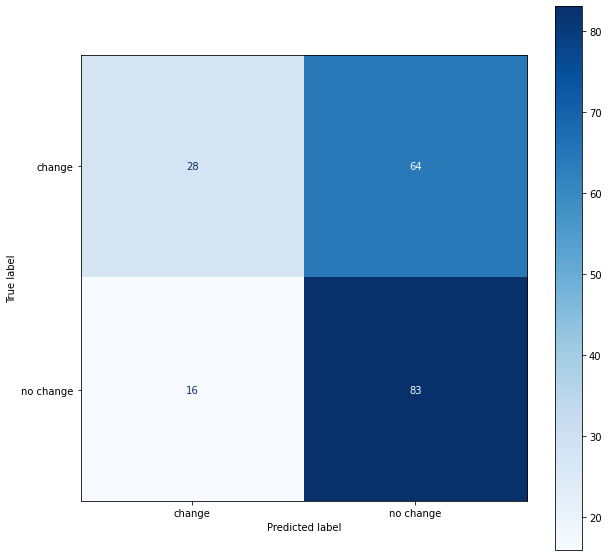

In [335]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [336]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

     change       0.64      0.30      0.84      0.41      0.51      0.24        92
  no change       0.56      0.84      0.30      0.67      0.51      0.27        99

avg / total       0.60      0.58      0.56      0.55      0.51      0.26       191



#### 2. Increase or Decrease

In [337]:
greenspan_df2 = greenspan_df
greenspan_df2 = greenspan_df2[greenspan_df2.action1 != 'no change']
X_train2, X_test2, y_train2, y_test2 = train_test_split(greenspan_df2['filter_text'], greenspan_df2['action'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")


vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())
model.fit(X_train2, y_train2)

Training target statistics: Counter({'no change': 232, 'change': 213})
Testing target statistics: Counter({'no change': 99, 'change': 92})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [338]:
cv_results = cross_val_score(model, X_train2, y_train2, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.54545455 0.59090909 0.63636364 0.47619048 0.66666667 0.57142857
 0.52380952 0.38095238 0.52380952 0.71428571]
Average 5-Fold CV Score: 0.562987012987013


In [364]:
# confusion matrix
y_pred2 = model.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred2)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_pred2)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
#fig, ax = plt.subplots(figsize=(10,10))
#_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

#### 3. Combined Results

In [340]:
y_test_df = pd.DataFrame(y_test)
y_test_df['y_pred'] = y_pred.tolist()
y_test_df2 = y_test_df[y_test_df.y_pred != 'no change']
my_list = y_test_df2.index.tolist()
change_df  = greenspan_df['filter_text'][greenspan_df['filter_text'].index.isin(my_list)]
y_pred3 = model.predict(change_df)
y_test_df3 = pd.DataFrame(change_df)
y_test_df3['y_pred'] = y_pred3.tolist()
change_action  = greenspan_df['action'][greenspan_df['action'].index.isin(my_list)]
y_test_df4 =  pd.merge(y_test_df3, change_action, left_index=True, right_index=True)
y_test_df2 = y_test_df
my_list = y_test_df2.index.tolist()
change_details = greenspan_df['action'][greenspan_df['action'].index.isin(my_list)]
y_test_df2['action'] = change_details
df1 = pd.DataFrame(y_test_df2, columns= ['action', 'y_pred'])
df2 = pd.DataFrame(y_test_df4, columns= ['action', 'y_pred'])
union = pd.concat([df1, df2])
results_df = union[union.y_pred != 'change']

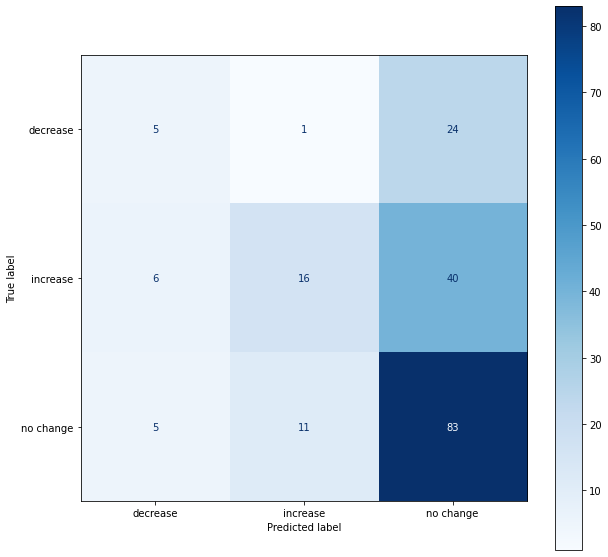

In [345]:
cm = confusion_matrix(results_df['action'], results_df['y_pred'])
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(results_df['action'])
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [346]:
print(classification_report_imbalanced(results_df['action'], results_df['y_pred']))

                   pre       rec       spe        f1       geo       iba       sup

   decrease       0.31      0.17      0.93      0.22      0.39      0.14        30
   increase       0.57      0.26      0.91      0.36      0.48      0.22        62
  no change       0.56      0.84      0.30      0.67      0.51      0.27        99

avg / total       0.53      0.54      0.60      0.50      0.48      0.23       191



### Chairman Ben S. Bernanke

In [347]:
ben_df = df_merge[df_merge['fed_chair'] == 'Ben Bernanke']
ben_df['speaker'].value_counts(sort=True)

Chairman Ben S. Bernanke           169
Vice Chairman Donald L. Kohn        46
Governor Daniel K. Tarullo          45
Governor Elizabeth A. Duke          44
Governor Randall S. Kroszner        43
Governor Frederic S. Mishkin        27
Governor Jerome H. Powell           24
Chair Janet L. Yellen               23
Vice Chair Janet L. Yellen          22
Governor Susan S. Bies              18
Governor Kevin Warsh                18
Governor Sarah Bloom Raskin         17
Governor Jeremy C. Stein            16
Vice Chairman Stanley Fischer       15
Governor Lael Brainard               9
Vice Chairman Roger W. Ferguson      6
Governor Donald L. Kohn              6
Governor Mark W. Olson               6
Name: speaker, dtype: int64

#### 1. Change vs No Change

In [350]:
ben_df['action1'] = np.where(ben_df['action']== 'no change', 'no change', 'change')

/var/folders/dz/4m0t9b0n3hlfz8rgtf943crr0000gn/T/ipykernel_23463/1311072723.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [351]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['action1'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 312, 'change': 77})
Testing target statistics: Counter({'no change': 124, 'change': 43})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [352]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.76923077 0.66666667 0.58974359 0.82051282 0.74358974 0.84615385
 0.69230769 0.92307692 0.84615385 0.68421053]
Average 5-Fold CV Score: 0.7581646423751687


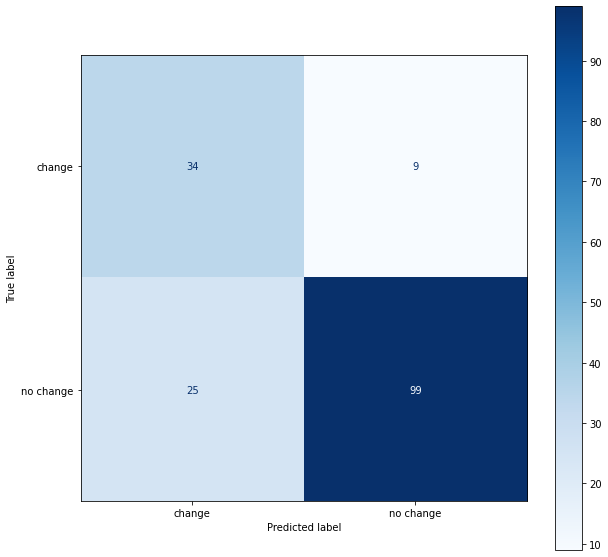

In [353]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [354]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

     change       0.58      0.79      0.80      0.67      0.79      0.63        43
  no change       0.92      0.80      0.79      0.85      0.79      0.63       124

avg / total       0.83      0.80      0.79      0.81      0.79      0.63       167



#### 2. Increase or Decrease

In [356]:
ben_df2 = ben_df
ben_df2 = ben_df2[ben_df2.action1 != 'no change']
X_train2, X_test2, y_train2, y_test2 = train_test_split(ben_df2['filter_text'], ben_df2['action'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")


vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
model = make_pipeline_imb(vectorizer, RandomUnderSampler(), MultinomialNB())
model.fit(X_train2, y_train2)

Training target statistics: Counter({'no change': 312, 'change': 77})
Testing target statistics: Counter({'no change': 124, 'change': 43})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('multinomialnb', MultinomialNB())])

In [357]:
cv_results = cross_val_score(model, X_train2, y_train2, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.77777778 1.         0.66666667 0.77777778 0.625      0.875
 1.         0.875      0.625      0.875     ]
Average 5-Fold CV Score: 0.8097222222222221


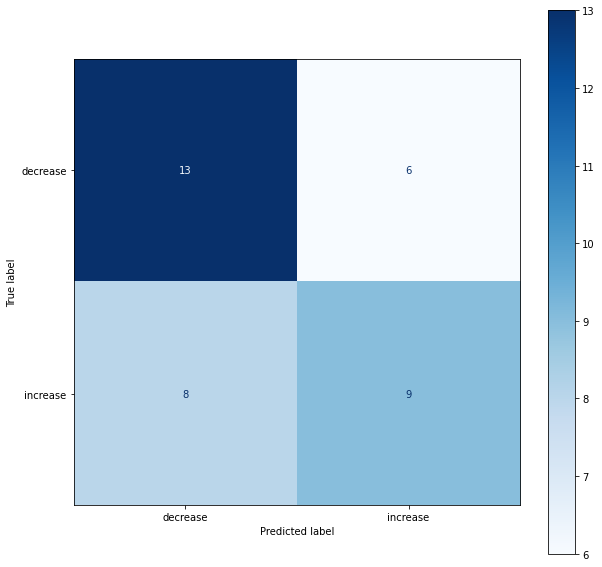

In [359]:
# confusion matrix
y_pred2 = model.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred2)
#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_pred2)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

#### 3. Combined Results

In [360]:
y_test_df = pd.DataFrame(y_test)
y_test_df['y_pred'] = y_pred.tolist()
y_test_df2 = y_test_df[y_test_df.y_pred != 'no change']
my_list = y_test_df2.index.tolist()
change_df  = ben_df['filter_text'][ben_df['filter_text'].index.isin(my_list)]
y_pred3 = model.predict(change_df)
y_test_df3 = pd.DataFrame(change_df)
y_test_df3['y_pred'] = y_pred3.tolist()
change_action  = ben_df['action'][ben_df['action'].index.isin(my_list)]
y_test_df4 =  pd.merge(y_test_df3, change_action, left_index=True, right_index=True)
y_test_df2 = y_test_df

In [361]:
my_list = y_test_df2.index.tolist()
change_details = ben_df['action'][ben_df['action'].index.isin(my_list)]
y_test_df2['action'] = change_details
df1 = pd.DataFrame(y_test_df2, columns= ['action', 'y_pred'])
df2 = pd.DataFrame(y_test_df4, columns= ['action', 'y_pred'])
union = pd.concat([df1, df2])
results_df = union[union.y_pred != 'change']

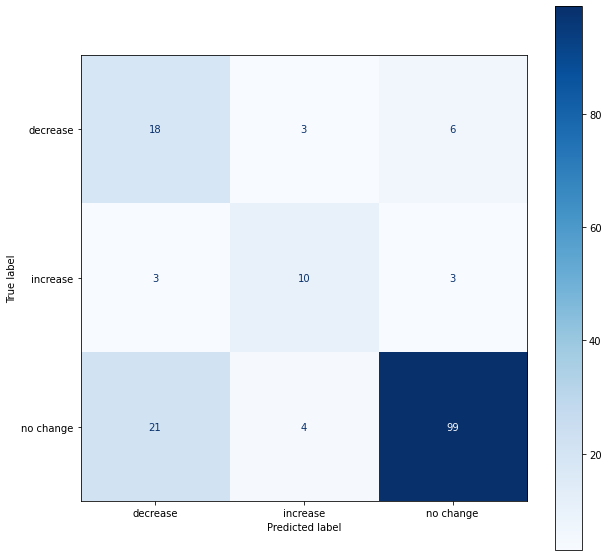

In [362]:
cm = confusion_matrix(results_df['action'], results_df['y_pred'])
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(results_df['action'])
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [363]:
print(classification_report_imbalanced(results_df['action'], results_df['y_pred']))

                   pre       rec       spe        f1       geo       iba       sup

   decrease       0.43      0.67      0.83      0.52      0.74      0.54        27
   increase       0.59      0.62      0.95      0.61      0.77      0.58        16
  no change       0.92      0.80      0.79      0.85      0.79      0.63       124

avg / total       0.81      0.76      0.81      0.78      0.78      0.61       167



### Predict FOMC Rate Decision (KNeighbors Classifier Sentiment Analysis)

### Chairman Alan Greenspan

In [366]:
greenspan_df['action1'] = np.where(greenspan_df['action']== 'no change', 'no change', 'change')

/var/folders/dz/4m0t9b0n3hlfz8rgtf943crr0000gn/T/ipykernel_23463/1429835765.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 1. Change vs No change

In [367]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['action1'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")


vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 232, 'change': 213})
Testing target statistics: Counter({'no change': 99, 'change': 92})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20, 21, 22, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30]},
                              scoring='accuracy'))])

In [368]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 8}
0.6079890560875512


In [369]:
model.set_params(gridsearchcv__estimator__n_neighbors=6)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=KNeighborsClassifier(n_neighbors=6),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20, 21, 22, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30]},
                              scoring='accuracy'))])

In [370]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.53333333 0.6        0.68888889 0.68888889 0.46666667 0.47727273
 0.61363636 0.65909091 0.52272727 0.56818182]
Average 5-Fold CV Score: 0.5818686868686869


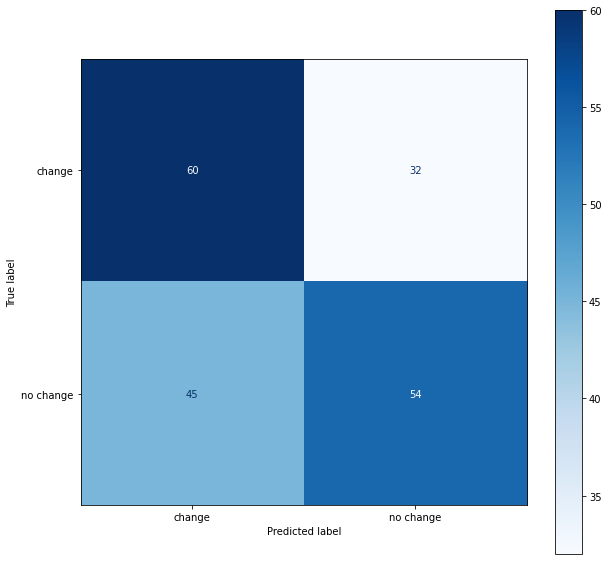

In [371]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [372]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

     change       0.57      0.65      0.55      0.61      0.60      0.36        92
  no change       0.63      0.55      0.65      0.58      0.60      0.35        99

avg / total       0.60      0.60      0.60      0.60      0.60      0.36       191



#### 2. Increase vs Decrease

In [374]:
greenspan_df2 = greenspan_df
greenspan_df2 = greenspan_df2[greenspan_df2.action1 != 'no change']
X_train2, X_test2, y_train2, y_test2 = train_test_split(greenspan_df2['filter_text'], greenspan_df2['action'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(greenspan_df['filter_text'], greenspan_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train2, y_train2)

Training target statistics: Counter({'no change': 232, 'change': 213})
Testing target statistics: Counter({'no change': 99, 'change': 92})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20, 21, 22, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30]},
                              scoring='accuracy'))])

In [375]:
cv_results = cross_val_score(model, X_train2, y_train2, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.63636364 0.68181818 0.77272727 0.52380952 0.66666667 0.42857143
 0.47619048 0.47619048 0.52380952 0.61904762]
Average 5-Fold CV Score: 0.5805194805194805


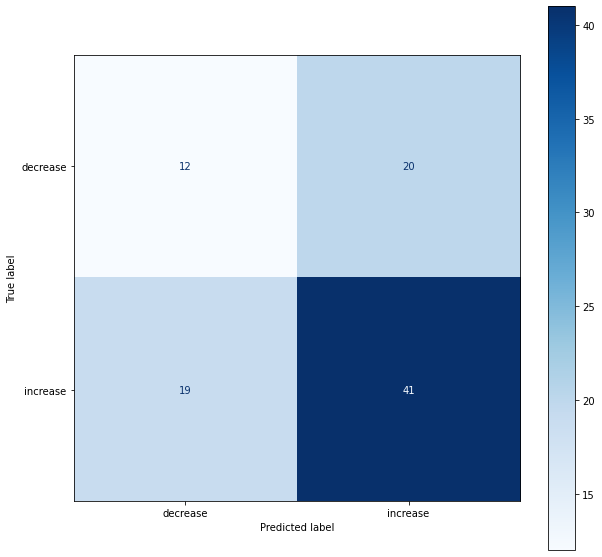

In [376]:
# confusion matrix
y_pred2 = model.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred2)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_pred2)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

#### 3. Combined Results

In [377]:
y_test_df = pd.DataFrame(y_test)
y_test_df['y_pred'] = y_pred.tolist()
y_test_df2 = y_test_df[y_test_df.y_pred != 'no change']
my_list = y_test_df2.index.tolist()
change_df  = greenspan_df['filter_text'][greenspan_df['filter_text'].index.isin(my_list)]
y_pred3 = model.predict(change_df)
y_test_df3 = pd.DataFrame(change_df)
y_test_df3['y_pred'] = y_pred3.tolist()
change_action  = greenspan_df['action'][greenspan_df['action'].index.isin(my_list)]
y_test_df4 =  pd.merge(y_test_df3, change_action, left_index=True, right_index=True)
y_test_df2 = y_test_df
my_list = y_test_df2.index.tolist()
change_details = greenspan_df['action'][greenspan_df['action'].index.isin(my_list)]
y_test_df2['action'] = change_details
df1 = pd.DataFrame(y_test_df2, columns= ['action', 'y_pred'])
df2 = pd.DataFrame(y_test_df4, columns= ['action', 'y_pred'])
union = pd.concat([df1, df2])
results_df = union[union.y_pred != 'change']

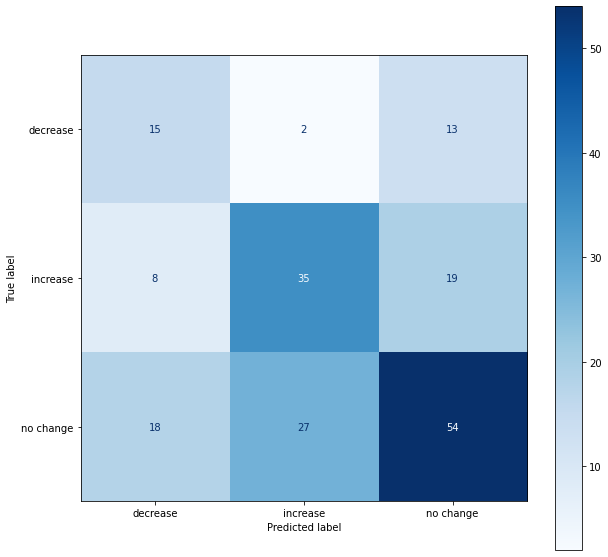

In [378]:
cm = confusion_matrix(results_df['action'], results_df['y_pred'])
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(results_df['action'])
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)


In [379]:
print(classification_report_imbalanced(results_df['action'], results_df['y_pred']))

                   pre       rec       spe        f1       geo       iba       sup

   decrease       0.37      0.50      0.84      0.42      0.65      0.41        30
   increase       0.55      0.56      0.78      0.56      0.66      0.43        62
  no change       0.63      0.55      0.65      0.58      0.60      0.35        99

avg / total       0.56      0.54      0.72      0.55      0.63      0.39       191



### Chairman Ben S. Bernanke

In [381]:
ben_df['action1'] = np.where(ben_df['action']== 'no change', 'no change', 'change')

/var/folders/dz/4m0t9b0n3hlfz8rgtf943crr0000gn/T/ipykernel_23463/1311072723.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### 1. Change vs No change

In [382]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['action1'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")


vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train, y_train)

Training target statistics: Counter({'no change': 312, 'change': 77})
Testing target statistics: Counter({'no change': 124, 'change': 43})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20, 21, 22, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30]},
                              scoring='accuracy'))])

In [383]:
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 10}
0.6746236559139784


In [384]:
model.set_params(gridsearchcv__estimator__n_neighbors=6)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=KNeighborsClassifier(n_neighbors=6),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20, 21, 22, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30]},
                              scoring='accuracy'))])

In [385]:
cv_results = cross_val_score(model, X_train, y_train, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.76923077 0.76923077 0.66666667 0.71794872 0.64102564 0.82051282
 0.46153846 0.69230769 0.64102564 0.65789474]
Average 5-Fold CV Score: 0.6837381916329285


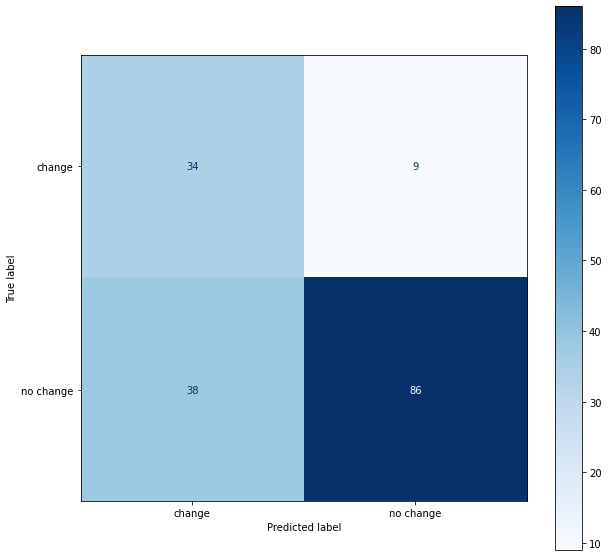

In [386]:
# confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_test)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [387]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

     change       0.47      0.79      0.69      0.59      0.74      0.55        43
  no change       0.91      0.69      0.79      0.79      0.74      0.54       124

avg / total       0.79      0.72      0.77      0.74      0.74      0.55       167



#### 2. Increase vs Decrease

In [389]:
ben_df2 = ben_df
ben_df2 = ben_df2[ben_df2.action1 != 'no change']
X_train2, X_test2, y_train2, y_test2 = train_test_split(ben_df2['filter_text'], ben_df2['action'], random_state=23, test_size=0.3)
#X_train, X_test, y_train, y_test = train_test_split(ben_df['filter_text'], ben_df['rate_change'].astype(str), random_state=23, test_size=0.3)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english', lowercase=False)
parameters = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5, scoring='accuracy')

model = make_pipeline_imb(vectorizer, RandomUnderSampler(), grid)
model.fit(X_train2, y_train2)

Training target statistics: Counter({'no change': 312, 'change': 77})
Testing target statistics: Counter({'no change': 124, 'change': 43})


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(lowercase=False, stop_words='english',
                                 strip_accents='ascii')),
                ('randomundersampler', RandomUnderSampler()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
                              param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14, 15, 16, 17, 18,
                                                          19, 20, 21, 22, 23,
                                                          24, 25, 26, 27, 28,
                                                          29, 30]},
                              scoring='accuracy'))])

In [390]:
cv_results = cross_val_score(model, X_train2, y_train2, cv=10)
print(cv_results)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_results)))

[0.77777778 0.88888889 0.77777778 1.         0.875      0.875
 1.         1.         0.75       0.875     ]
Average 5-Fold CV Score: 0.8819444444444444


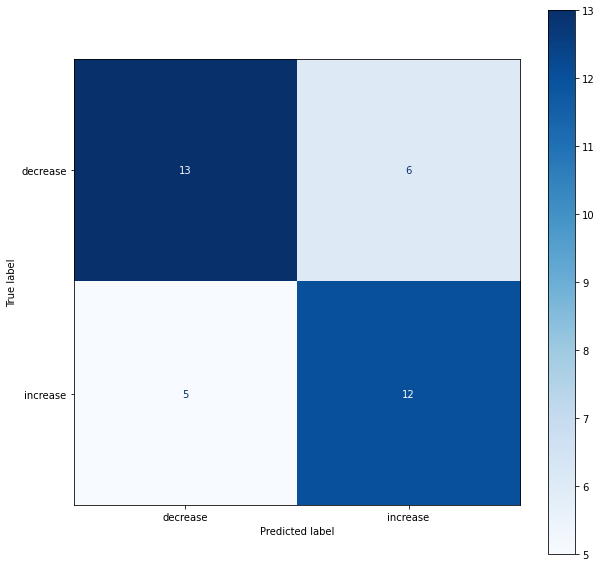

In [391]:
# confusion matrix
y_pred2 = model.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred2)
#print(cm)

#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(y_pred2)
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

#### 3. Combined Results

In [392]:
y_test_df = pd.DataFrame(y_test)
y_test_df['y_pred'] = y_pred.tolist()
y_test_df2 = y_test_df[y_test_df.y_pred != 'no change']
my_list = y_test_df2.index.tolist()
change_df  = ben_df['filter_text'][ben_df['filter_text'].index.isin(my_list)]
y_pred3 = model.predict(change_df)
y_test_df3 = pd.DataFrame(change_df)
y_test_df3['y_pred'] = y_pred3.tolist()
change_action  = ben_df['action'][ben_df['action'].index.isin(my_list)]
y_test_df4 =  pd.merge(y_test_df3, change_action, left_index=True, right_index=True)
y_test_df2 = y_test_df
my_list = y_test_df2.index.tolist()
change_details = ben_df['action'][ben_df['action'].index.isin(my_list)]
y_test_df2['action'] = change_details
df1 = pd.DataFrame(y_test_df2, columns= ['action', 'y_pred'])
df2 = pd.DataFrame(y_test_df4, columns= ['action', 'y_pred'])
union = pd.concat([df1, df2])
results_df = union[union.y_pred != 'change']

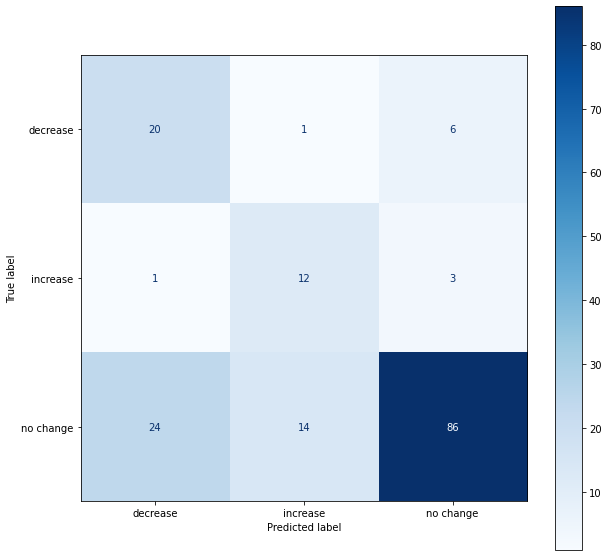

In [393]:
cm = confusion_matrix(results_df['action'], results_df['y_pred'])
#print(cm)
#cm = confusion_matrix(np.arange(25), np.arange(25))
labels = np.unique(results_df['action'])
cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
_none = cmp.plot(ax=ax, cmap=plt.cm.Blues)

In [394]:
print(classification_report_imbalanced(results_df['action'], results_df['y_pred']))

                   pre       rec       spe        f1       geo       iba       sup

   decrease       0.44      0.74      0.82      0.56      0.78      0.60        27
   increase       0.44      0.75      0.90      0.56      0.82      0.67        16
  no change       0.91      0.69      0.79      0.79      0.74      0.54       124

avg / total       0.79      0.71      0.81      0.73      0.75      0.56       167



# 3. Conclusion